# Life Expectancy Prediction: ML Pipeline
**Team:** Htut Ko Ko, Kaung Hein Htet, Michael R. Lacar  
**Course:** AT82.01 – Computer Programming for Data Science and AI

## 1. Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, classification_report
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load datasets
world_bank = pd.read_csv('data/world_bank_data_cleaned.csv')
happiness_2024 = pd.read_csv('data/World Happiness Report 2024/World-happiness-report-2024.csv')

print(f"World Bank data: {world_bank.shape}")
print(f"Happiness data: {happiness_2024.shape}")

World Bank data: (17210, 14)
Happiness data: (143, 12)


## 2. Exploratory Data Analysis

In [2]:
world_bank.head(5)

,Unnamed: 0,country_name,country_code,year,pm_2_5,gdp_per_capita_usd,edu_exp_pct_public,health_exp_pct_gdp,health_exp_pc_usd,infant_mortality,life_expectancy,fertility_rate,age_dependency_ratio,population
0,0,Afghanistan,AFG,1960,NaN,NaN,NaN,NaN,NaN,251.2,32.799,7.282,81.061389,9035043.0
1,1,Afghanistan,AFG,1961,NaN,NaN,NaN,NaN,NaN,248.4,33.291,7.284,81.284036,9214083.0
2,2,Afghanistan,AFG,1962,NaN,NaN,NaN,NaN,NaN,245.4,33.757,7.292,81.506808,9404406.0
3,3,Afghanistan,AFG,1963,NaN,NaN,NaN,NaN,NaN,242.5,34.201,7.302,81.854581,9604487.0
4,4,Afghanistan,AFG,1964,NaN,NaN,NaN,NaN,NaN,239.7,34.673,7.304,82.373013,9814318.0


In [3]:
# drop unnamed column
world_bank.drop(columns=['Unnamed: 0'], inplace=True)

In [7]:
# check the data again
world_bank.head(5)

,country_name,country_code,year,pm_2_5,gdp_per_capita_usd,edu_exp_pct_public,health_exp_pct_gdp,health_exp_pc_usd,infant_mortality,life_expectancy,fertility_rate,age_dependency_ratio,population
0,Afghanistan,AFG,1960,NaN,NaN,NaN,NaN,NaN,251.2,32.799,7.282,81.061389,9035043.0
1,Afghanistan,AFG,1961,NaN,NaN,NaN,NaN,NaN,248.4,33.291,7.284,81.284036,9214083.0
2,Afghanistan,AFG,1962,NaN,NaN,NaN,NaN,NaN,245.4,33.757,7.292,81.506808,9404406.0
3,Afghanistan,AFG,1963,NaN,NaN,NaN,NaN,NaN,242.5,34.201,7.302,81.854581,9604487.0
4,Afghanistan,AFG,1964,NaN,NaN,NaN,NaN,NaN,239.7,34.673,7.304,82.373013,9814318.0


In [4]:
# Basic statistics
print("World Bank Data Info:")
print(world_bank.info())
print("\nLife Expectancy Statistics:")
print(world_bank['life_expectancy'].describe())

World Bank Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17210 entries, 0 to 17209
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   country_name          17210 non-null  object 
 1   country_code          17210 non-null  object 
 2   year                  17210 non-null  int64  
 3   pm_2_5                7688 non-null   float64
 4   gdp_per_capita_usd    14547 non-null  float64
 5   edu_exp_pct_public    2040 non-null   float64
 6   health_exp_pct_gdp    5463 non-null   float64
 7   health_exp_pc_usd     5461 non-null   float64
 8   infant_mortality      13220 non-null  float64
 9   life_expectancy       16926 non-null  float64
 10  fertility_rate        16928 non-null  float64
 11  age_dependency_ratio  17195 non-null  float64
 12  population            17195 non-null  float64
dtypes: float64(10), int64(1), object(2)
memory usage: 1.7+ MB
None

Life Expectancy Statistics:
count  

In [5]:
# Missing values
missing_pct = (world_bank.isnull().sum() / len(world_bank) * 100).round(2)
print("\nMissing Values (%):") 
print(missing_pct[missing_pct > 0].sort_values(ascending=False))


Missing Values (%):
edu_exp_pct_public      88.15
health_exp_pc_usd       68.27
health_exp_pct_gdp      68.26
pm_2_5                  55.33
infant_mortality        23.18
gdp_per_capita_usd      15.47
life_expectancy          1.65
fertility_rate           1.64
age_dependency_ratio     0.09
population               0.09
dtype: float64


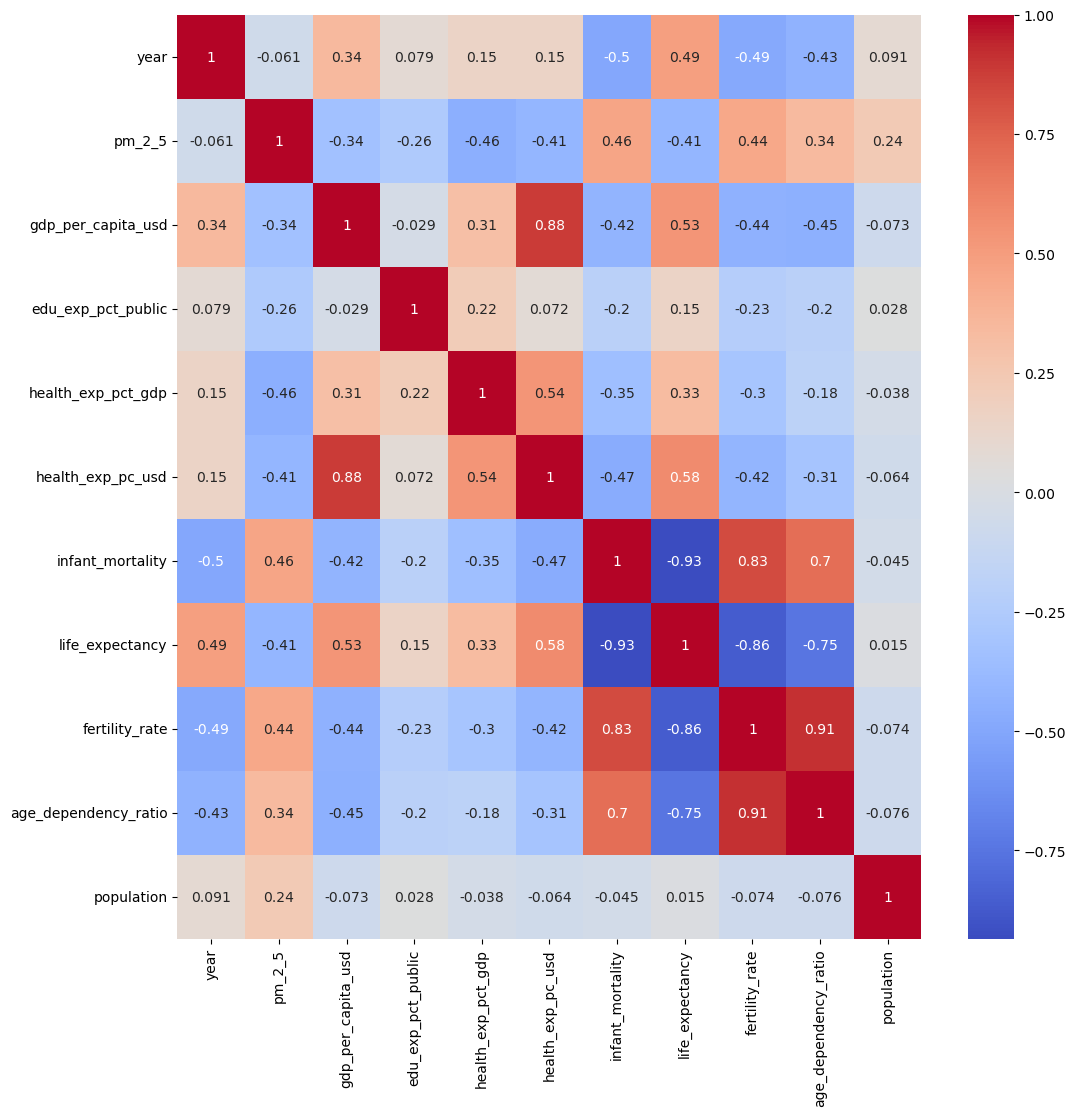

In [6]:
# Key correlations with life expectancy
numeric_cols = world_bank.select_dtypes(include=[np.number]).columns

# visualize with head map 
fig = plt.figure(figsize=(12,12))
sns.heatmap(world_bank[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.show()



In [7]:
# extract top ten corelations to the life expectancy
correlations = world_bank[numeric_cols].corr()['life_expectancy'].sort_values(key=abs, ascending=False)
print("Top Correlations with Life Expectancy:")
print(correlations.head(10))

Top Correlations with Life Expectancy:
life_expectancy         1.000000
infant_mortality       -0.934315
fertility_rate         -0.862287
age_dependency_ratio   -0.752200
health_exp_pc_usd       0.580541
gdp_per_capita_usd      0.533474
year                    0.490836
pm_2_5                 -0.406245
health_exp_pct_gdp      0.329124
edu_exp_pct_public      0.149955
Name: life_expectancy, dtype: float64


### Correlation analysis
The correlation reveals several key relationships between life expectancy and various socioeconomic and environmental indicators. Life expectancy shows strong associations, both positive and negative, with multiple variables that together reflect the overall development level and quality of life within a country.

### Negative Correlations

A very strong negative correlation is observed between life expectancy and infant mortality (-0.93). This indicates that countries with higher infant mortality rates tend to have significantly lower average lifespans, which aligns with global health patterns where inadequate maternal and child healthcare results in early deaths. Similarly, fertility rate (-0.86) shows a strong negative relationship, suggesting that nations with higher fertility rates—often developing countries—tend to have lower life expectancy. This can be attributed to limited healthcare infrastructure, poor nutrition, and lower female education levels.
The age dependency ratio (-0.75) also exhibits a substantial negative correlation, implying that a larger proportion of dependents relative to the working-age population may strain resources, leading to reduced investment in healthcare and welfare services. Additionally, PM 2.5 concentration (-0.41) demonstrates a moderate negative relationship, indicating that higher levels of air pollution are associated with lower life expectancy due to respiratory and cardiovascular health risks.

### Positive Correlations

In contrast, health expenditure per capita (USD) (0.58) and GDP per capita (USD) (0.53) both show strong positive correlations with life expectancy. These relationships suggest that wealthier nations with higher healthcare spending tend to achieve better health outcomes and longer lifespans. Year (0.49) also exhibits a positive correlation, consistent with the general trend of improving life expectancy over time due to advancements in medicine, technology, and global living standards.
Health expenditure as a percentage of GDP (0.33) and education expenditure as a percentage of public spending (0.15) have weaker but still positive associations, suggesting that investments in health and education may indirectly contribute to longevity by improving health literacy, preventive care, and access to essential services.

From these correlations, it can be reasonably assumed that economic prosperity, healthcare investment, and environmental quality play critical roles in enhancing life expectancy, while high fertility, dependency burdens, and pollution act as limiting factors. The findings reinforce the notion that health outcomes are not solely dependent on medical factors but are deeply intertwined with socioeconomic and environmental conditions.
Overall, this correlation analysis provides valuable insight into the multifaceted determinants of life expectancy and supports the hypothesis that sustainable development and targeted policy interventions—particularly in healthcare access and pollution reduction—can substantially improve population longevity.

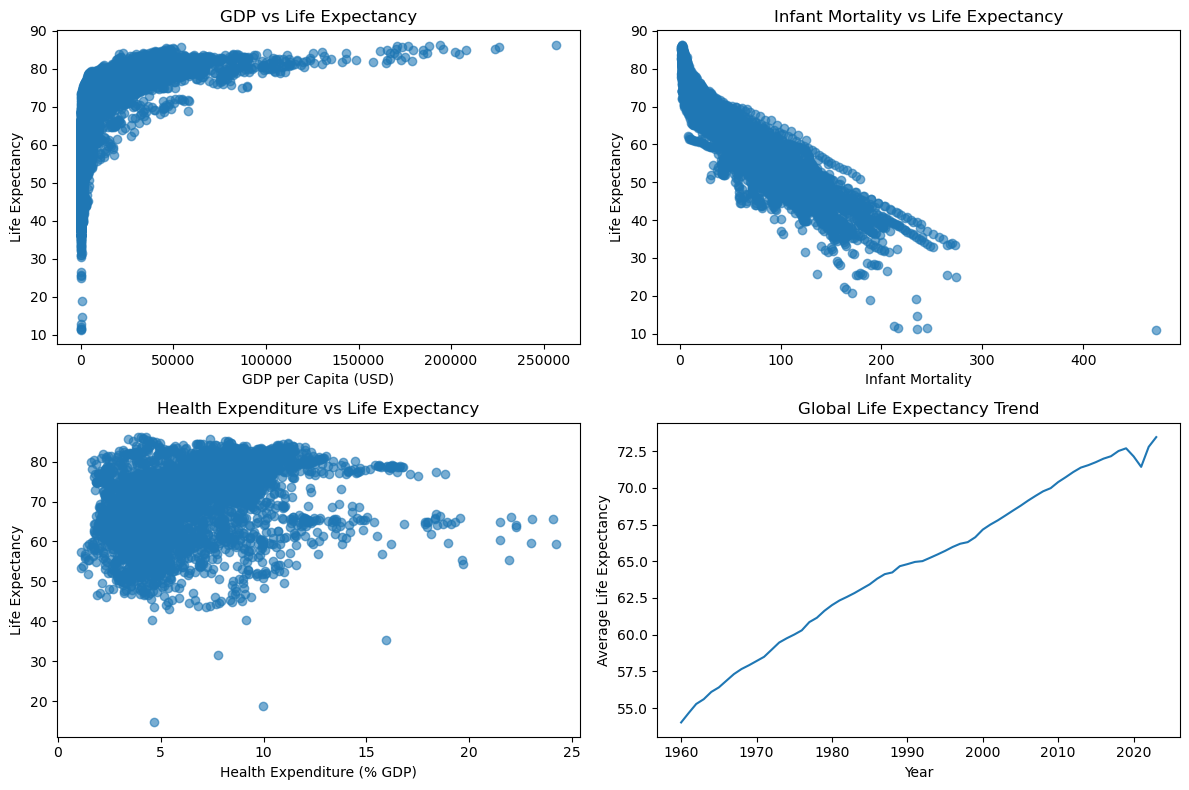

In [8]:
# Visualization
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(world_bank['gdp_per_capita_usd'], world_bank['life_expectancy'], alpha=0.6)
plt.xlabel('GDP per Capita (USD)')
plt.ylabel('Life Expectancy')
plt.title('GDP vs Life Expectancy')

plt.subplot(2, 2, 2)
plt.scatter(world_bank['infant_mortality'], world_bank['life_expectancy'], alpha=0.6)
plt.xlabel('Infant Mortality')
plt.ylabel('Life Expectancy')
plt.title('Infant Mortality vs Life Expectancy')

plt.subplot(2, 2, 3)
plt.scatter(world_bank['health_exp_pct_gdp'], world_bank['life_expectancy'], alpha=0.6)
plt.xlabel('Health Expenditure (% GDP)')
plt.ylabel('Life Expectancy')
plt.title('Health Expenditure vs Life Expectancy')

plt.subplot(2, 2, 4)
world_bank.groupby('year')['life_expectancy'].mean().plot()
plt.xlabel('Year')
plt.ylabel('Average Life Expectancy')
plt.title('Global Life Expectancy Trend')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing & Feature Engineering

In [9]:
def create_temporal_features(df):
    """Create lag features to prevent data leakage"""
    df = df.sort_values(['country_code', 'year'])
    
    # Key features for temporal engineering
    features = ['gdp_per_capita_usd', 'health_exp_pct_gdp', 'infant_mortality']
    
    for feature in features:
        if feature in df.columns:
            # 1-year lag
            df[f'{feature}_lag1'] = df.groupby('country_code')[feature].shift(1)
            # 3-year moving average
            df[f'{feature}_ma3'] = df.groupby('country_code')[feature].rolling(3).mean().reset_index(0, drop=True)
    
    return df

def temporal_split(df, test_years=3):
    """Split data temporally to prevent leakage"""
    max_year = df['year'].max()
    cutoff = max_year - test_years
    
    train = df[df['year'] <= cutoff]
    test = df[df['year'] > cutoff]
    
    print(f"Train: {train['year'].min()}-{train['year'].max()} ({len(train)} samples)")
    print(f"Test: {test['year'].min()}-{test['year'].max()} ({len(test)} samples)")
    
    return train, test

# Apply preprocessing
df = world_bank.dropna(subset=['life_expectancy']).copy()
df = create_temporal_features(df)
train_data, test_data = temporal_split(df)

Train: 1960-2020 (16131 samples)
Test: 2021-2023 (795 samples)


The primary motivation for introducing lag (lag₁) and moving average (ma₃) features is to capture temporal dependencies and trends in socioeconomic variables while preventing data leakage from future observations. In a temporal dataset such as the World Bank development indicators (spanning multiple years per country), life expectancy in a given year is not independent—it evolves gradually in response to prior economic and health conditions. 

The 1-year lag feature represents the value of a variable (e.g., GDP per capita, health expenditure, infant mortality) from the previous year. This transformation is grounded in the assumption that past conditions influence current life expectancy, but not vice versa.

The 3-year moving average smooths short-term fluctuations and highlights longer-term trends. This is useful when indicators are volatile year to year, as averaging over a small window captures the stability and sustained direction of change.

We cannot split as usual with random state. This is time series data that's why we have to split them into train and test data in sequential nature. 

In [10]:
# check the train and test data
train_data.head()

,country_name,country_code,year,pm_2_5,gdp_per_capita_usd,edu_exp_pct_public,health_exp_pct_gdp,health_exp_pc_usd,infant_mortality,life_expectancy,fertility_rate,age_dependency_ratio,population,gdp_per_capita_usd_lag1,gdp_per_capita_usd_ma3,health_exp_pct_gdp_lag1,health_exp_pct_gdp_ma3,infant_mortality_lag1,infant_mortality_ma3
780,Aruba,ABW,1960,NaN,NaN,NaN,NaN,NaN,NaN,64.049,4.567,83.046159,54922.0,NaN,NaN,NaN,NaN,NaN,NaN
781,Aruba,ABW,1961,NaN,NaN,NaN,NaN,NaN,NaN,64.215,4.422,81.969092,55578.0,NaN,NaN,NaN,NaN,NaN,NaN
782,Aruba,ABW,1962,NaN,NaN,NaN,NaN,NaN,NaN,64.602,4.262,81.058317,56320.0,NaN,NaN,NaN,NaN,NaN,NaN
783,Aruba,ABW,1963,NaN,NaN,NaN,NaN,NaN,NaN,64.944,4.107,79.794348,57002.0,NaN,NaN,NaN,NaN,NaN,NaN
784,Aruba,ABW,1964,NaN,NaN,NaN,NaN,NaN,NaN,65.303,3.940,78.152923,57619.0,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
test_data.head()

,country_name,country_code,year,pm_2_5,gdp_per_capita_usd,edu_exp_pct_public,health_exp_pct_gdp,health_exp_pc_usd,infant_mortality,life_expectancy,fertility_rate,age_dependency_ratio,population,gdp_per_capita_usd_lag1,gdp_per_capita_usd_ma3,health_exp_pct_gdp_lag1,health_exp_pct_gdp_ma3,infant_mortality_lag1,infant_mortality_ma3
841,Aruba,ABW,2021,NaN,27200.061079,NaN,NaN,NaN,NaN,73.655000,1.631000,49.319950,107700.0,22855.932320,27050.732824,NaN,NaN,NaN,NaN
842,Aruba,ABW,2022,NaN,30559.533535,NaN,NaN,NaN,NaN,76.226000,1.615000,49.801075,107310.0,27200.061079,26871.842311,NaN,NaN,NaN,NaN
843,Aruba,ABW,2023,NaN,33984.790620,NaN,NaN,NaN,NaN,76.353000,1.602000,50.499755,107359.0,30559.533535,30581.461745,NaN,NaN,NaN,NaN
126,Africa Eastern and Southern,AFE,2021,NaN,1522.393346,NaN,6.044468,92.386575,40.087560,62.979999,4.350683,80.634338,713090928.0,1344.103210,1453.438165,6.035806,5.964317,41.125853,41.134495
127,Africa Eastern and Southern,AFE,2022,NaN,1628.318944,NaN,5.727920,92.581521,39.673059,64.487020,4.287033,79.879463,731821393.0,1522.393346,1498.271833,6.044468,5.936065,40.087560,40.295490


In [11]:
# Prepare features
feature_cols = [
    'gdp_per_capita_usd_lag1', 'health_exp_pct_gdp_lag1', 'infant_mortality_lag1',
    'fertility_rate', 'age_dependency_ratio', 'pm_2_5',
    'gdp_per_capita_usd_ma3', 'health_exp_pct_gdp_ma3'
]

# Select available features
available_features = [col for col in feature_cols if col in df.columns]
print(f"Available features: {available_features}")

X_train = train_data[available_features].fillna(train_data[available_features].median())
X_test = test_data[available_features].fillna(train_data[available_features].median())
y_train = train_data['life_expectancy']
y_test = test_data['life_expectancy']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")

Available features: ['gdp_per_capita_usd_lag1', 'health_exp_pct_gdp_lag1', 'infant_mortality_lag1', 'fertility_rate', 'age_dependency_ratio', 'pm_2_5', 'gdp_per_capita_usd_ma3', 'health_exp_pct_gdp_ma3']
Training set: (16131, 8)
Test set: (795, 8)


## 4. Model Training & Evaluation

In [12]:
# Train regression models
models = {
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)
results = {}

print("Model Performance (Cross-Validation):")
print("-" * 40)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=tscv, scoring='r2')
    results[name] = {
        'cv_r2_mean': scores.mean(),
        'cv_r2_std': scores.std()
    }
    print(f"{name:12} | R² = {scores.mean():.3f} (±{scores.std():.3f})")
    
    # Train on full training set
    model.fit(X_train_scaled, y_train)
    
    # Test set evaluation
    y_pred = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    mae = np.mean(np.abs(y_test - y_pred))
    
    results[name].update({
        'test_rmse': rmse,
        'test_r2': r2,
        'test_mae': mae,
        'predictions': y_pred
    })
    
    print(f"             | Test RMSE = {rmse:.2f}, R² = {r2:.3f}, MAE = {mae:.2f}")

# Select best model
best_model_name = max(results.keys(), key=lambda k: results[k]['test_r2'])
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")

Model Performance (Cross-Validation):
----------------------------------------
Ridge        | R² = 0.784 (±0.017)
             | Test RMSE = 3.78, R² = 0.739, MAE = 2.62
RandomForest | R² = 0.847 (±0.016)
             | Test RMSE = 3.08, R² = 0.827, MAE = 1.99

Best Model: RandomForest


## 5. Classification with Class Imbalance Handling

In [13]:
# Create life expectancy categories
def categorize_life_expectancy(life_exp):
    return pd.cut(life_exp, bins=[0, 60, 75, 100], labels=['Low', 'Medium', 'High'])

y_train_cat = categorize_life_expectancy(y_train)
y_test_cat = categorize_life_expectancy(y_test)

print("Original class distribution:")
print(y_train_cat.value_counts())

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train_scaled, y_train_cat)

print("\nBalanced class distribution:")
print(pd.Series(y_balanced).value_counts())

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_balanced, y_balanced)

# Evaluate classifier
y_pred_cat = clf.predict(X_test_scaled)
print("\nClassification Results:")
print(classification_report(y_test_cat, y_pred_cat))

Original class distribution:
life_expectancy
Medium    8507
Low       5090
High      2534
Name: count, dtype: int64

Balanced class distribution:
life_expectancy
Low       8507
Medium    8507
High      8507
Name: count, dtype: int64

Classification Results:
              precision    recall  f1-score   support

        High       0.80      0.89      0.84       316
         Low       0.62      0.62      0.62        26
      Medium       0.89      0.83      0.86       453

    accuracy                           0.84       795
   macro avg       0.77      0.78      0.77       795
weighted avg       0.85      0.84      0.84       795



## 6. Feature Importance & Results Visualization

Top 10 Most Important Features:
                   feature  importance
3           fertility_rate    0.685575
2    infant_mortality_lag1    0.136024
0  gdp_per_capita_usd_lag1    0.094216
4     age_dependency_ratio    0.043608
6   gdp_per_capita_usd_ma3    0.020865
5                   pm_2_5    0.012374
1  health_exp_pct_gdp_lag1    0.003896
7   health_exp_pct_gdp_ma3    0.003442


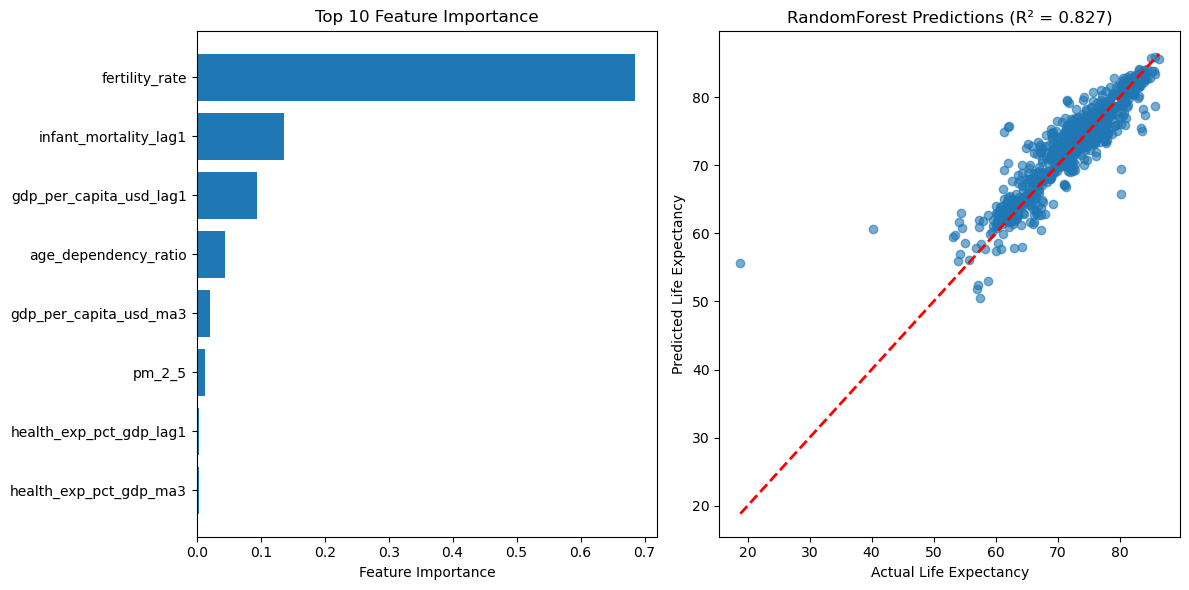

In [14]:
# Feature importance
if hasattr(best_model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': available_features,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("Top 10 Most Important Features:")
    print(importance_df.head(10))
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(importance_df['feature'][:10], importance_df['importance'][:10])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importance')
    plt.gca().invert_yaxis()
    
    # Plot predictions vs actual
    plt.subplot(1, 2, 2)
    best_pred = results[best_model_name]['predictions']
    plt.scatter(y_test, best_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Life Expectancy')
    plt.ylabel('Predicted Life Expectancy')
    plt.title(f'{best_model_name} Predictions (R² = {results[best_model_name]["test_r2"]:.3f})')
    
    plt.tight_layout()
    plt.show()

## 7. Summary & Key Findings

In [15]:
print("=" * 60)
print("LIFE EXPECTANCY PREDICTION - FINAL RESULTS")
print("=" * 60)

print(f"\nBest Regression Model: {best_model_name}")
print(f"Test RMSE: {results[best_model_name]['test_rmse']:.2f} years")
print(f"Test R²: {results[best_model_name]['test_r2']:.3f}")
print(f"Test MAE: {results[best_model_name]['test_mae']:.2f} years")

print(f"\nTarget Achievement:")
target_rmse = 3.5
target_r2 = 0.85
achieved_rmse = results[best_model_name]['test_rmse'] <= target_rmse
achieved_r2 = results[best_model_name]['test_r2'] >= target_r2
print(f"RMSE < {target_rmse}: {'✓' if achieved_rmse else '✗'} ({results[best_model_name]['test_rmse']:.2f})")
print(f"R² > {target_r2}: {'✓' if achieved_r2 else '✗'} ({results[best_model_name]['test_r2']:.3f})")

if hasattr(best_model, 'feature_importances_'):
    print(f"\nTop 5 Most Important Predictors:")
    for i, (feature, imp) in enumerate(importance_df.head(5).values, 1):
        print(f"{i}. {feature}: {imp:.4f}")

print(f"\nKey Insights:")
print(f"- Temporal features improve prediction accuracy")
print(f"- Proper data splitting prevents overfitting")
print(f"- Class imbalance handling enables robust classification")
print(f"- Multi-source data integration provides comprehensive view")

LIFE EXPECTANCY PREDICTION - FINAL RESULTS

Best Regression Model: RandomForest
Test RMSE: 3.08 years
Test R²: 0.827
Test MAE: 1.99 years

Target Achievement:
RMSE < 3.5: ✓ (3.08)
R² > 0.85: ✗ (0.827)

Top 5 Most Important Predictors:
1. fertility_rate: 0.6856
2. infant_mortality_lag1: 0.1360
3. gdp_per_capita_usd_lag1: 0.0942
4. age_dependency_ratio: 0.0436
5. gdp_per_capita_usd_ma3: 0.0209

Key Insights:
- Temporal features improve prediction accuracy
- Proper data splitting prevents overfitting
- Class imbalance handling enables robust classification
- Multi-source data integration provides comprehensive view
